# SMOTE and Standard Evaluation in SHAP:
- Load the best SMOTE Model and a comparison Standard Model.
- Evaluate the differences in SHAP.

These are the Standard imports. Other imports are handled through the model and tools imports.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics, accuracy_score
import shap
from Tools.shap_manager import SHAPmanager

Here we load the previously collected one hot encoded features which gives us a total of 322 features and 2 target variables.

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

C:\Users\adi_s\AppData\Local\Temp\ipykernel_17844\1876235566.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


Split the data for training and testing of each Model.

In [4]:
# First remove the labels in the actual data.
temp1 = data.drop(columns=['label', 'attack_cat'])
# Set y1 as the binary label.
y1 = data['label']
# Split the data into 80% train and 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    temp1, y1, test_size=0.2, random_state=42)

The Neural Network is based on torch and requires torch tensors. They are loaded into the DataLoader object to handle batching.

In [5]:
# Select the batch size. This directly impacts the effectiveness of some sampling methods.
batch_size = 128
# Convert each train and test set into tensors.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Convert to a Tensor Dataset which stores both the train and test sets.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add the Tensor Datasets into a DataLoader object which manages the batching. Shuffle function is used on the train set but not the test set.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We load the best SMOTE Model and run it on the test set.

c:\Users\adi_s\Desktop\LSTM\Models\models.py:262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
Testing: 100%|██████████| 3969/3969 [0

Test Loss: 0.0205, Test Accuracy: 0.9877, Test F1: 0.9881


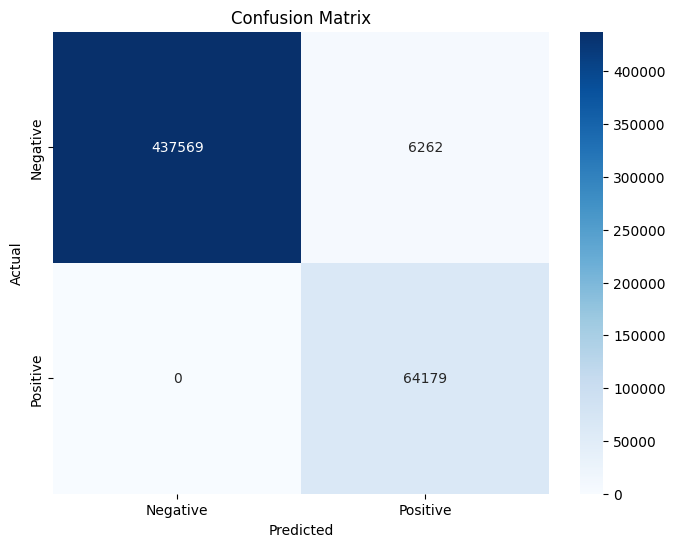

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 256
save_dir = './Models/saved_models/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
model1.load_model('./Models/saved_models/02/smote/01-256/PB_epoch_5.pth')
model1.test(test_loader)
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Here we load a benchmark Standard Model and run it on the same test set for comparison.

c:\Users\adi_s\Desktop\LSTM\Models\models.py:262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
Testing: 100%|██████████| 3969/3969 [0

Test Loss: 0.0212, Test Accuracy: 0.9919, Test F1: 0.9917


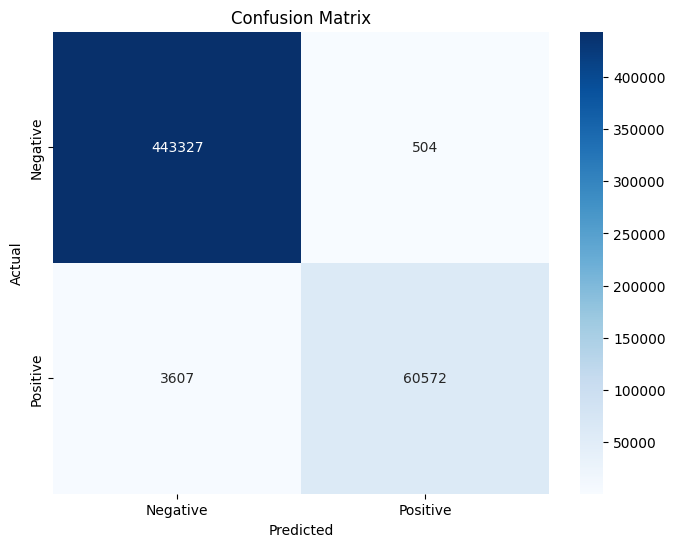

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model2 = NNdynamic(n_features, fc_size, device, save_dir)
model2.load_model('./Models/saved_models/02/standard/01/PB_epoch_5.pth')
model2.test(test_loader)
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model2.test_predicted)

Now we create a background used for both the models. Usually we would want a much larger background.

In [8]:
background = X_test.sample(n=10000)
background = background.reset_index(drop=True)
background = torch.tensor(background.values, dtype=torch.float32)

Now we take a sample of the incorrect predictions on threats to evaluate.

In [9]:
X_test['actual'] = y_test
X_test['pred'] = model2.test_predicted

In [10]:
sample = X_test[(X_test['actual'] == 1) & (X_test['pred'] != 1)]
sample = sample.sample(n=1000)
sample = sample.reset_index(drop=True)
X_test = X_test.drop(columns=['actual', 'pred'])
sample = sample.drop(columns=['actual', 'pred'])
sample = torch.tensor(sample.values, dtype=torch.float32)

We load the background into the Explainer and generate an explainer object for evaluation in the shap class.

In [ ]:
xp1 = shap.DeepExplainer(model1, background)
xp2 = shap.DeepExplainer(model2, background)

: 

In [ ]:
explainer1 = xp1(sample)
explainer2 = xp2(sample)

We initialise the shap class with the two different explainers (one for each model). The binary NN version requires feature names to be given from the columns.

In [44]:
sm1 = SHAPmanager(explainer1, label_type='binary', feature_names=X_test.columns)
sm2 = SHAPmanager(explainer2, label_type='binary', feature_names=X_test.columns)

When viewing the summary plots we can see that the SMOTE model has significantly larger shap values particularly for source and destination IP addresses and ct_state_ttl. Low importance features found in the standard model such as dload and proto_udp are also not found in the top 20 for the SMOTE model. For both models ct_state_ttl, dttl, and sttl seem to be the most important features in predicting the label along with IP features. Lets review it without the ip addresses quickly. 

SMOTE


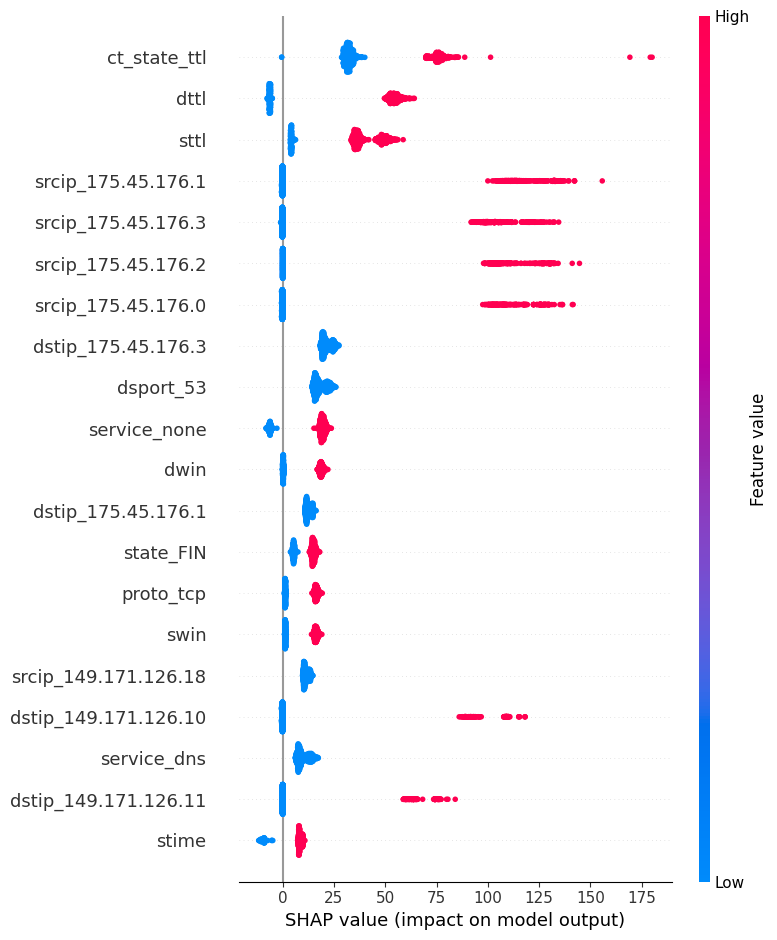

Standard


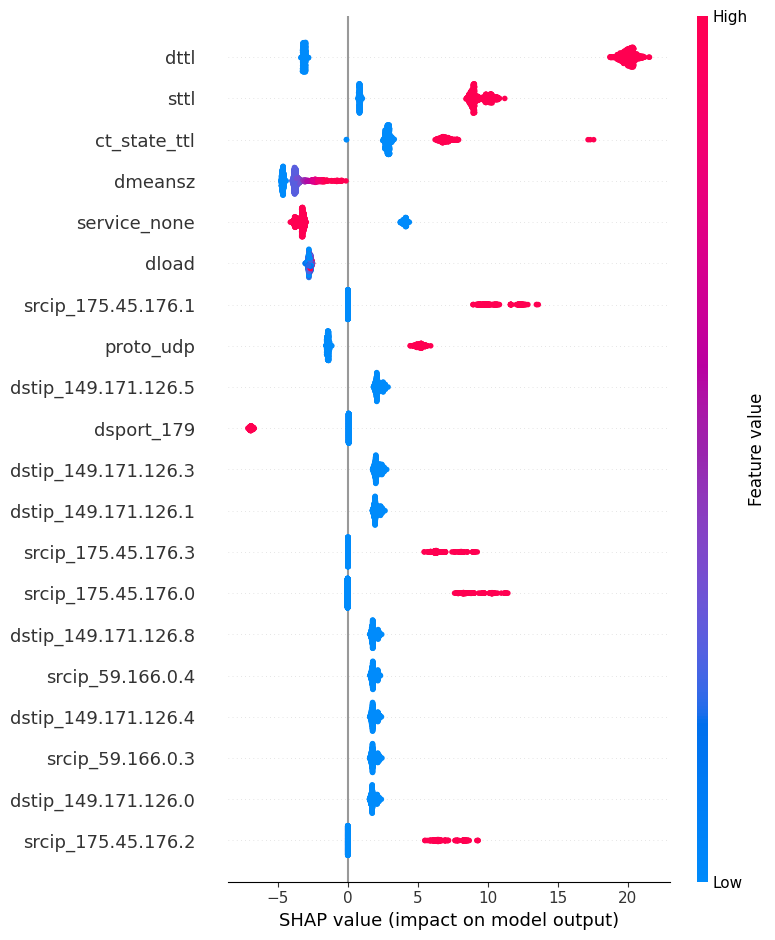

In [45]:
print('SMOTE')
sm1.plot_summary(max_features=20)
print('Standard')
sm2.plot_summary(max_features=20)

In [46]:
ips = []
for i in sm1.explainer.data.columns:
    if i.startswith('srcip_') or i.startswith('dstip_'):
        ips.append(i)
sm1.remove_features(ips)
sm2.remove_features(ips)

This plot shows that in general for the top 20 features in the SMOTE model, they tend to have a much higher positive shap value. Infact there seems to be only one feature which shows low importance in the top 20 (proto_udp). High and low values for ct_state_ttl contribute positively in model prediction. For dttl only high values contribute positively to model prediction whereas low values contribute negatively. For sttl both high and low values contribute positively in model predictions but much more positively for high values. When comparing the SMOTE model it seems to scale up the positive contributions for features compared to the Standard Model. Many features are not the same in the remaining top 20. For example dmeansz is not even considered in the top 20 for SMOTE wheras it is one of the most negatively contributing features for the Standard model. When looking at the binary labels we view it as red meaning they are present (1) and blue as not-present in the data (0).

SMOTE


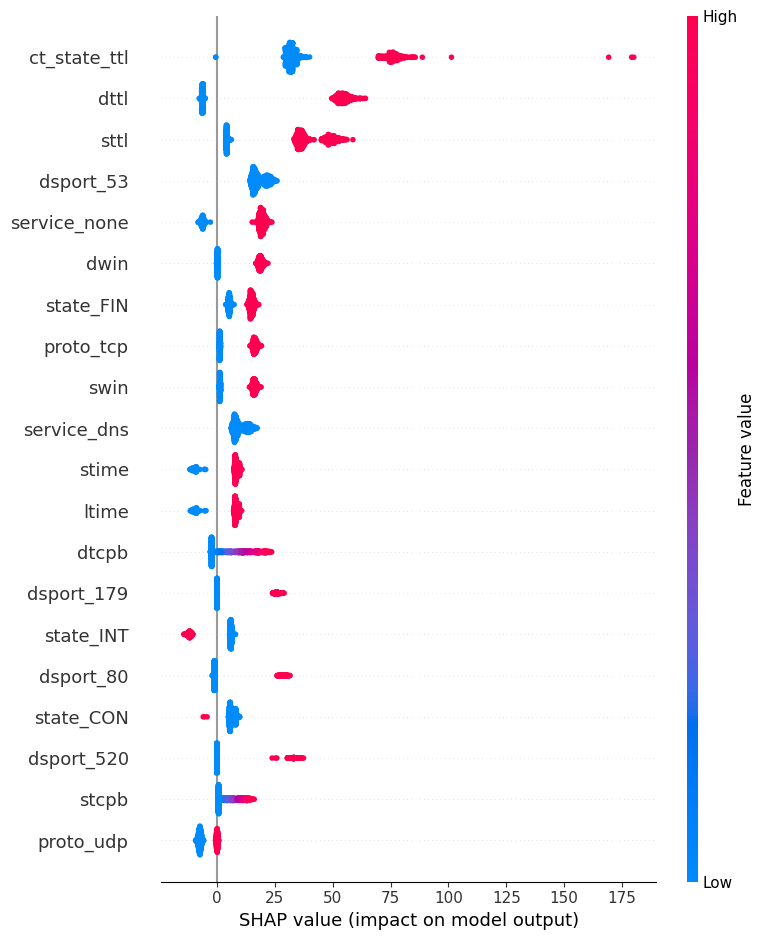

Standard


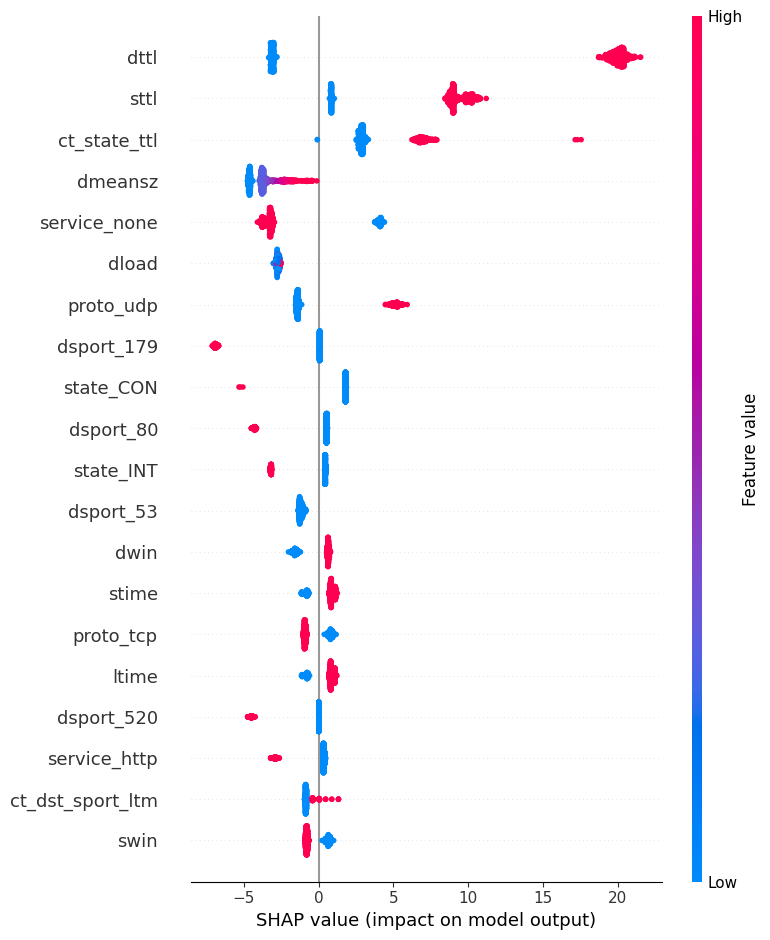

In [47]:
print('SMOTE')
sm1.plot_summary(max_features=20)
print('Standard')
sm2.plot_summary(max_features=20)

Lets check the dependence plots for the top 3 features for both Models checking the difference for the top 2 interactions.

For the SMOTE Model the top interactions are ct_dst_src_ltm and ct_srv_dst with them all having mostly low values. For the Standard Model the top 2 interactions are sintpkt and sjit and again these seem to be mostly low values.

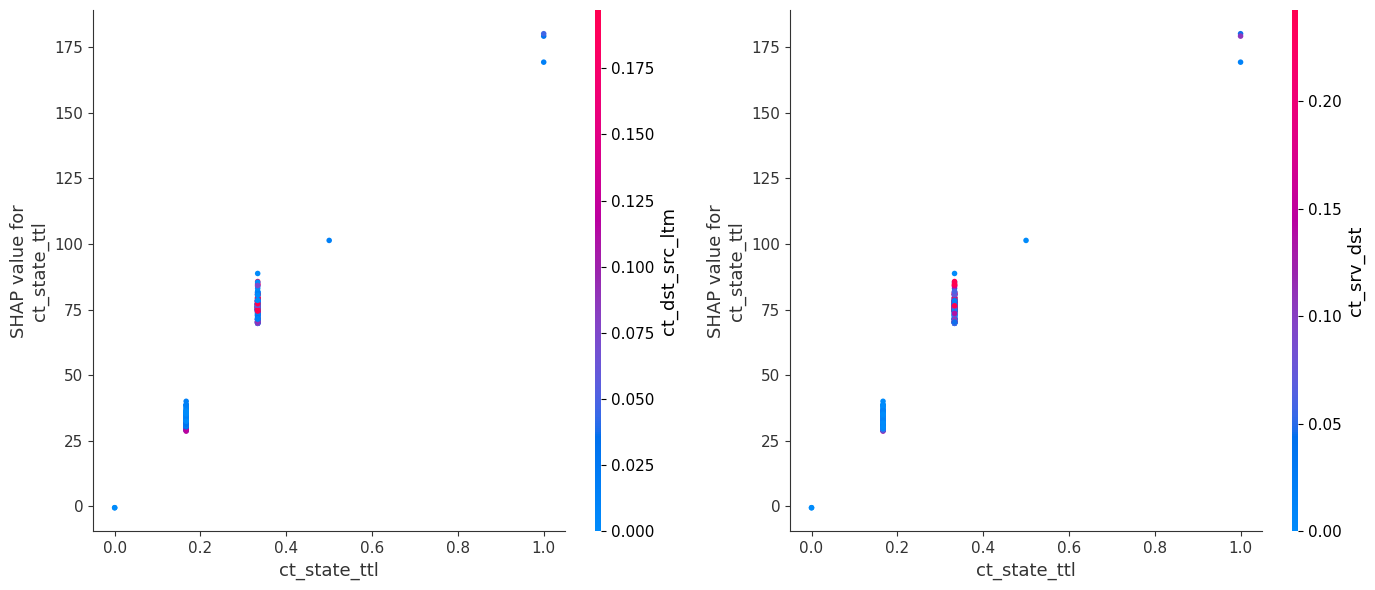

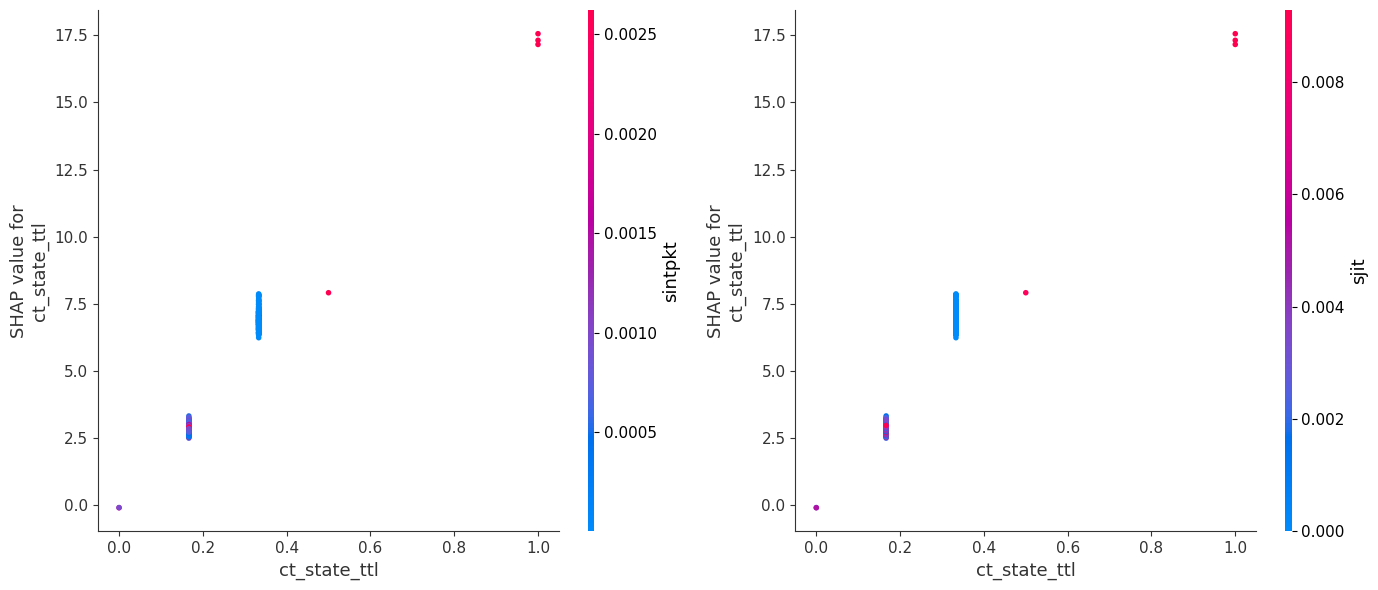

In [48]:
sm1.plot_dependence('ct_state_ttl', n_interaction=2)
sm2.plot_dependence('ct_state_ttl', n_interaction=2)

Lets combine the ct column and see what it says overall about the variable.

In [49]:
sm1.stacked_group('ct', limit=30, calculation='average')
sm2.stacked_group('ct', limit=30, calculation='average')

Now it shows stime and ltime and the features with the highest interactions overall for the ct variable in SMOTE Model and almost all the time values are high values. For the Standard Model the highest interactions for ct are found in smeansz (which we found to have low feature importance before) and sbytes. Both the interaction values for the Standard Model are mostly low values.  

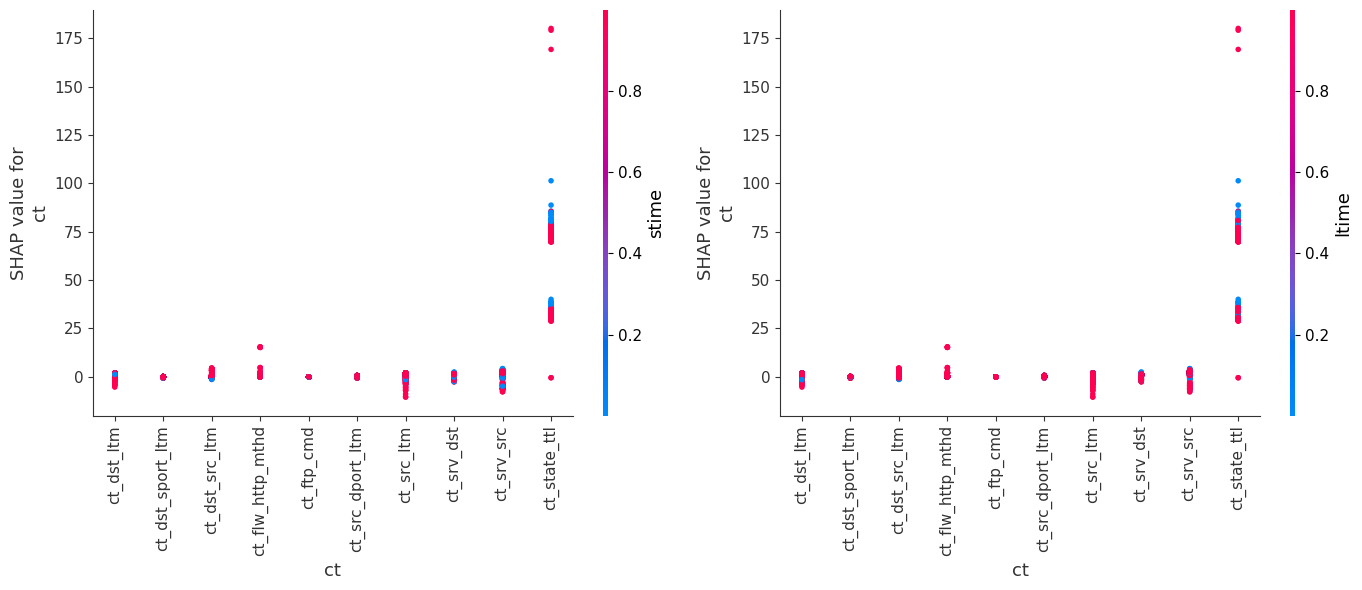

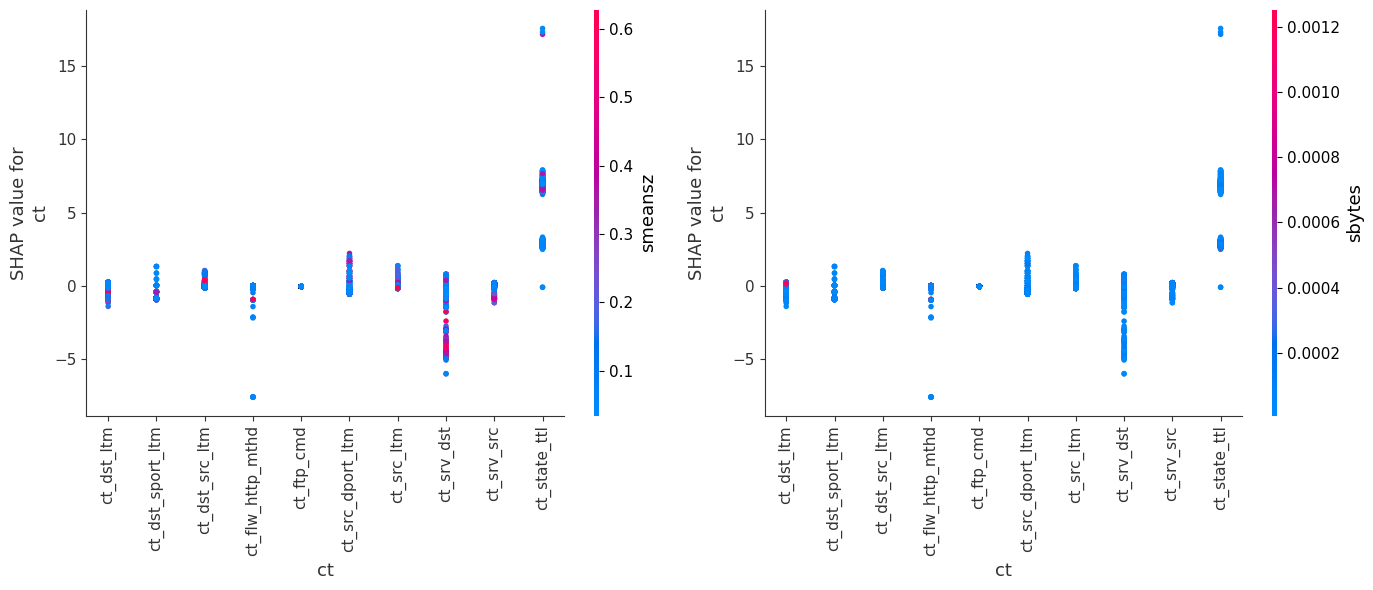

In [50]:
sm1.plot_dependence('ct', n_interaction=2)
sm2.plot_dependence('ct', n_interaction=2)

In [51]:
sm1.restore_data()
sm2.restore_data()

Lets check the other variables that were in the top 3.

For the SMOTE Model we see the highest interactions for sttl in ct_dst_src_ltm and ct_srv_dst which are mostly low values. The sttl values found in the data are also mostly high values. For the Standard Model sintpkt and sjit appear again as the strongest interactions and again they appear to be low values very similar to the ct_state_ttl interactions.

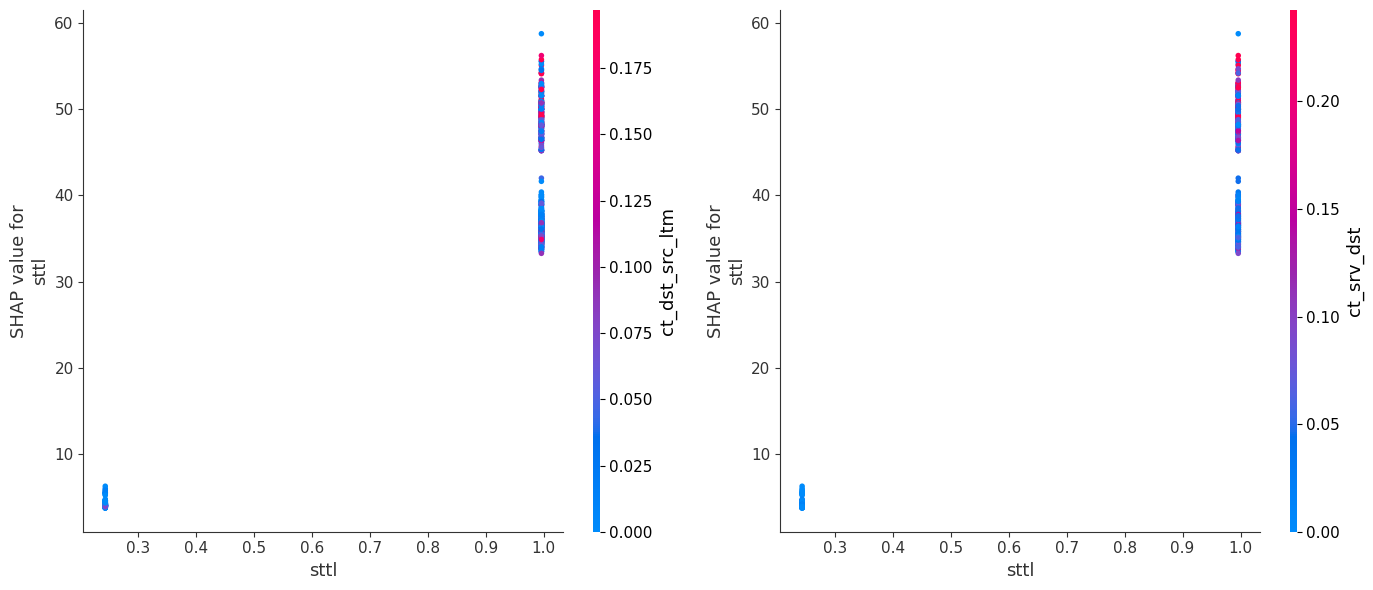

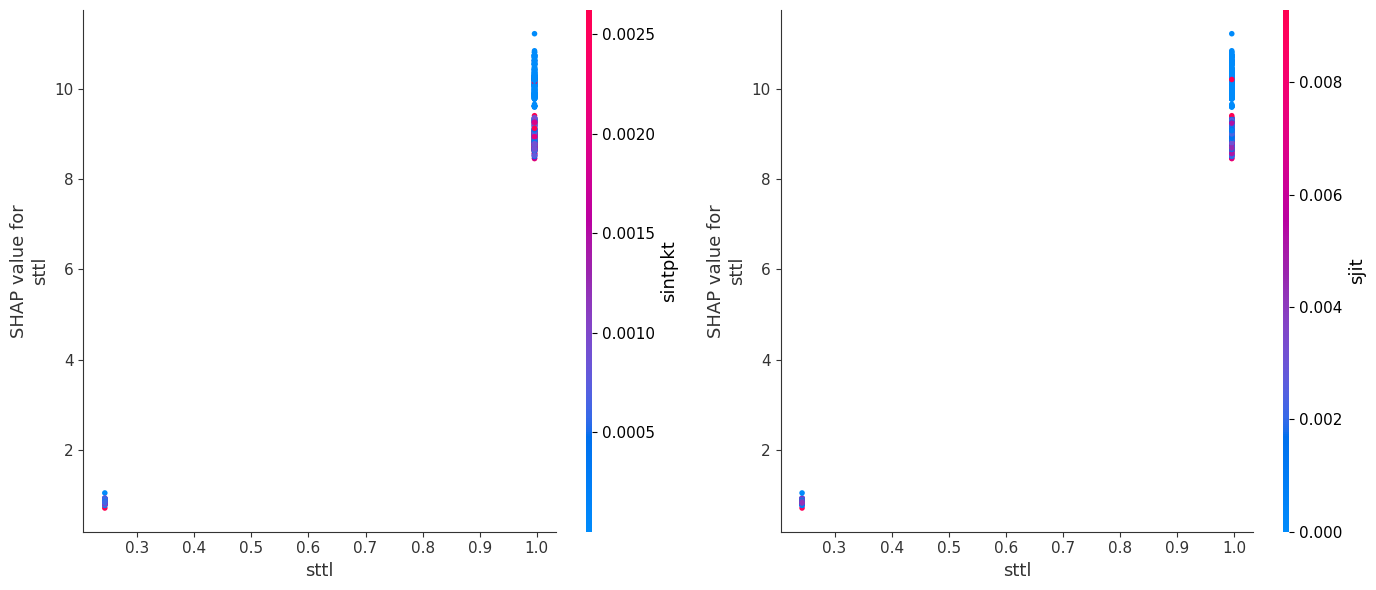

In [52]:
sm1.plot_dependence('sttl', n_interaction=2)
sm2.plot_dependence('sttl', n_interaction=2)

Lets check the last in the top 3.

Interestingly we find the interactions to be the exactly the same a sttl for both Models. However this time for the SMOTE Model ct_dst_src_ltm and ct_srv_dst have much more lower values. For the Standard Model sintpkt and sjit also have much lower interaction values.

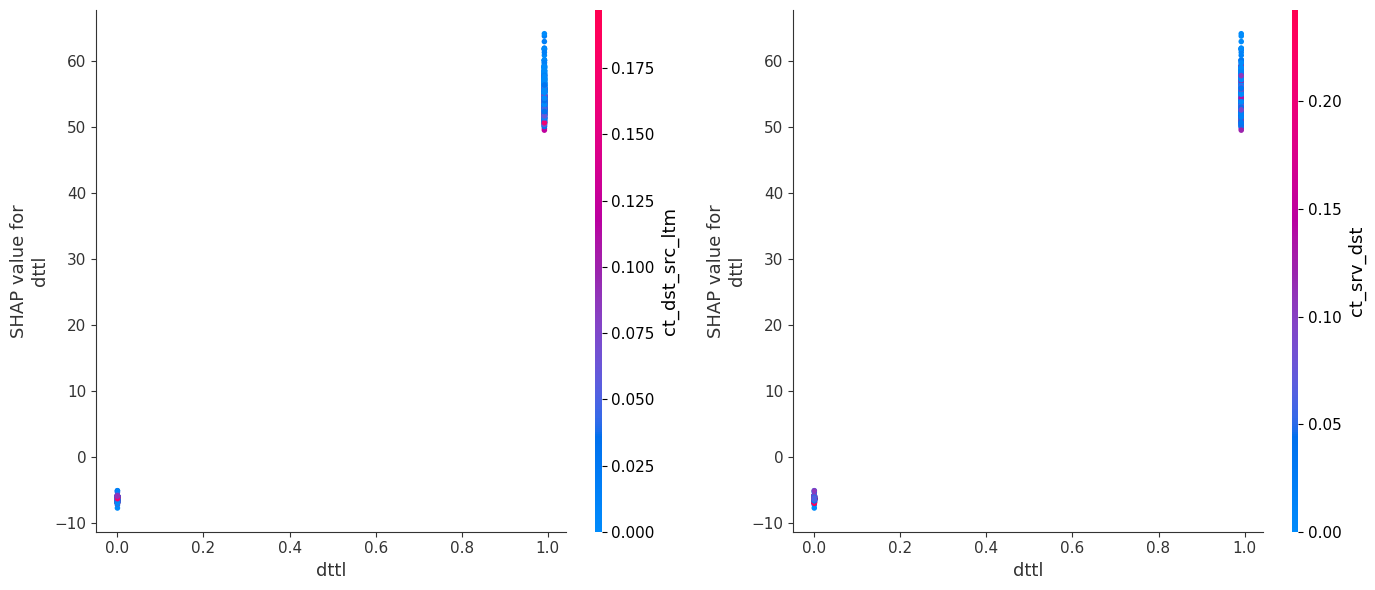

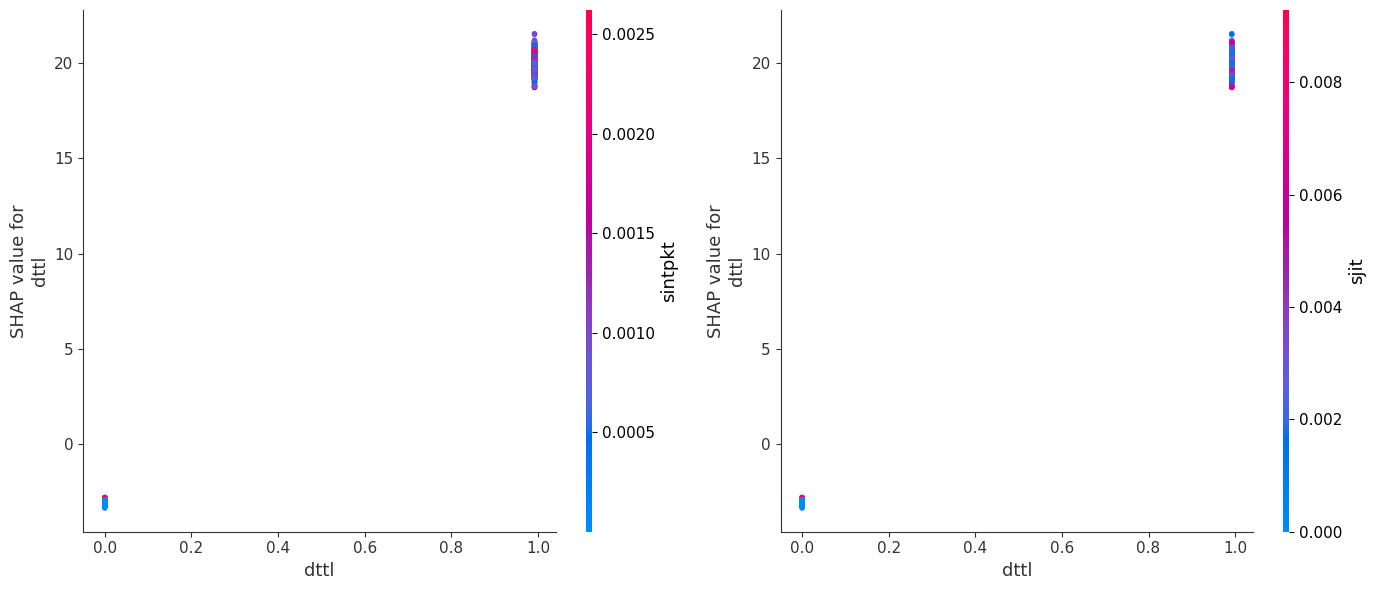

In [53]:
sm1.plot_dependence('dttl', n_interaction=2)
sm2.plot_dependence('dttl', n_interaction=2)

When Evaluating Binaries it should be noted that we are evaluating both the presence and absence of the binary value in the Dependence Plot. In general we are viewing how the variable changes with the predicted label.

Lets check Destination Ports to see if there are differences.

The Source Ports seem to have mostly the same importance in terms of calculating their absolute average and also the exact same interactions. However Source Port 47439 are the complete opposite where in the SMOTE Model it has low feature importance but in the Standard Model it has high feature importance.

In [54]:
sm1.restore_data()
sm2.restore_data()

In [55]:
sm1.stacked_group('sport', limit=30, calculation='average')
sm2.stacked_group('sport', limit=30, calculation='average')

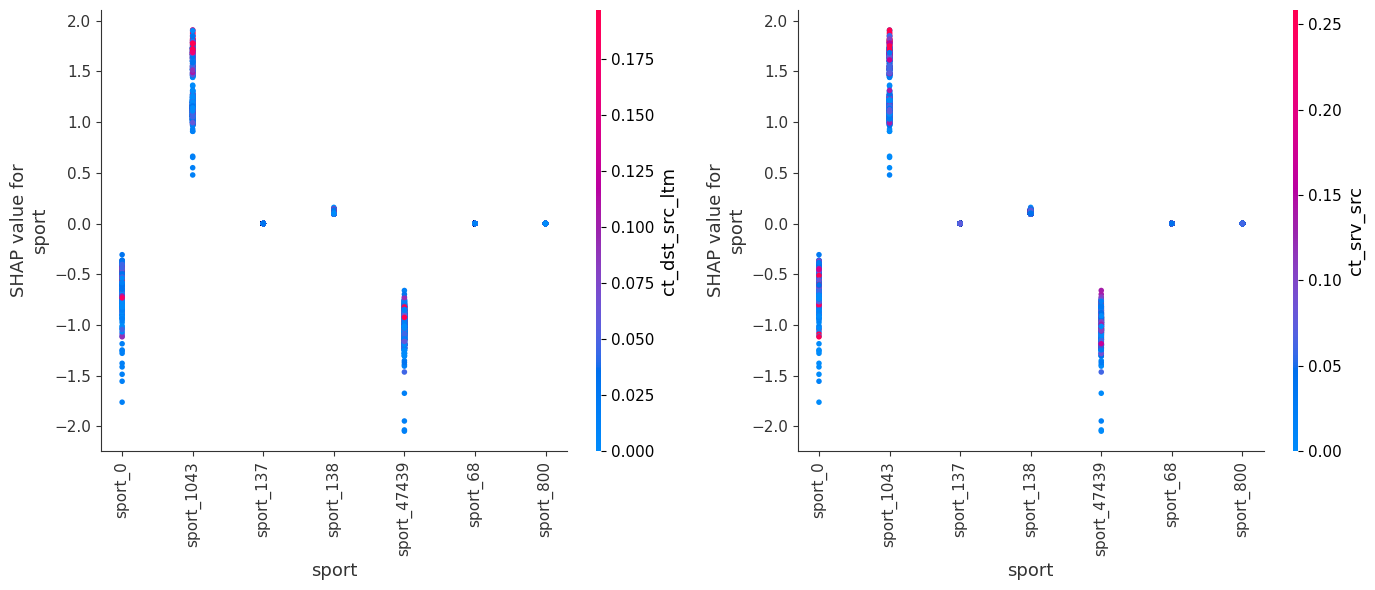

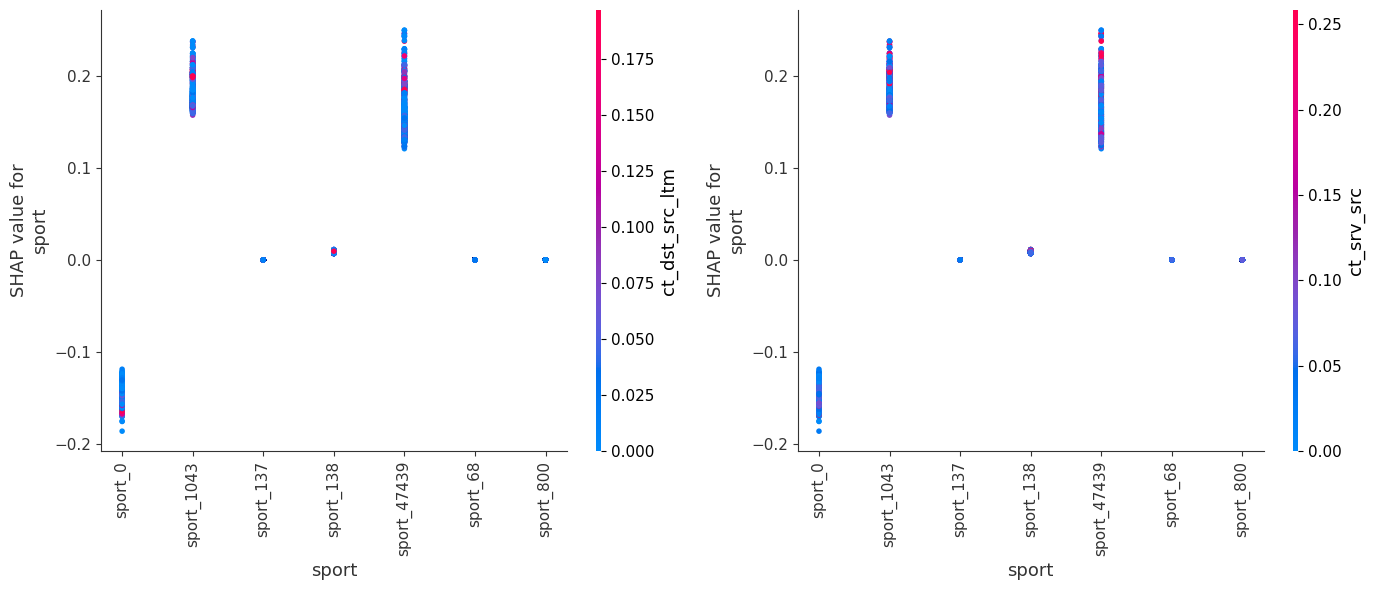

In [56]:
sm1.plot_dependence('sport', n_interaction=2)
sm2.plot_dependence('sport', n_interaction=2)

Lets check Destination Ports.

In [64]:
sm1.restore_data()
sm2.restore_data()

In [65]:
sm1.stacked_group('dsport', limit=20, calculation='average')
sm2.stacked_group('dsport', limit=20, calculation='average')

There seems to be a very large difference in feature importance for Destination Ports for the two Models. For the SMOTE Model Ports 1723, 179, 21, 445, 514, 53, and 80 show very high importance. For the Standard Model the Ports are considered significantly less important with all of them having negative shap values except for Ports 21, 6881, and 80. The Interactions seem almost the same for both models except that they are reversed in the top 2 positions for ct_srv_dst and ct_dst_src_ltm.

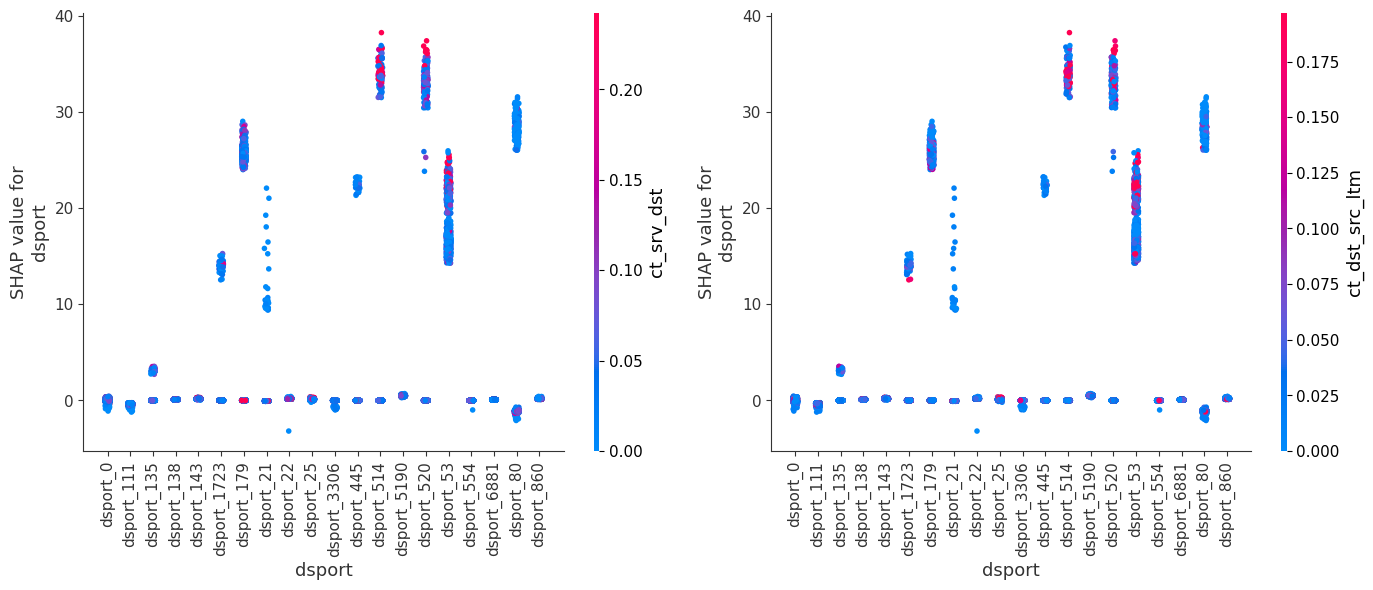

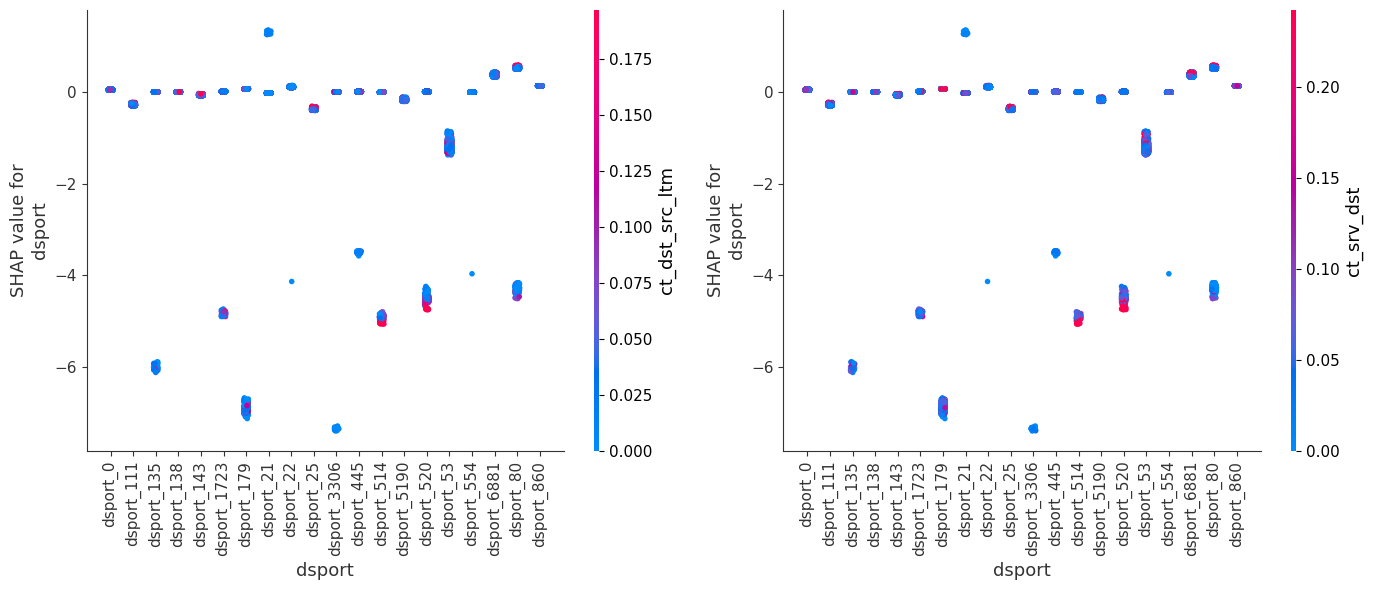

In [66]:
sm1.plot_dependence('dsport', n_interaction=2, x_jitter=0.2)
sm2.plot_dependence('dsport', n_interaction=2, x_jitter=0.2)

Lets check Protocols

In [68]:
sm1.restore_data()
sm2.restore_data()

In [69]:
sm1.stacked_group('proto', limit=30, calculation='average')
sm2.stacked_group('proto', limit=30, calculation='average')

For Protocols the SMOTE model considers the presence or absence of Protocols TCP very important and UDP less important (negative) whereas the Standard Model considers UDP much more important. The main interaction for SMOTE and Standard are ct_dst_src_ltm and the secondary interactions are different where SMOTE considers ct_srv_dst important and the Standard model is ct_srv_src. This means the SMOTE model thinks the destination ct_srv is more important to the source compared to the Standard Model.

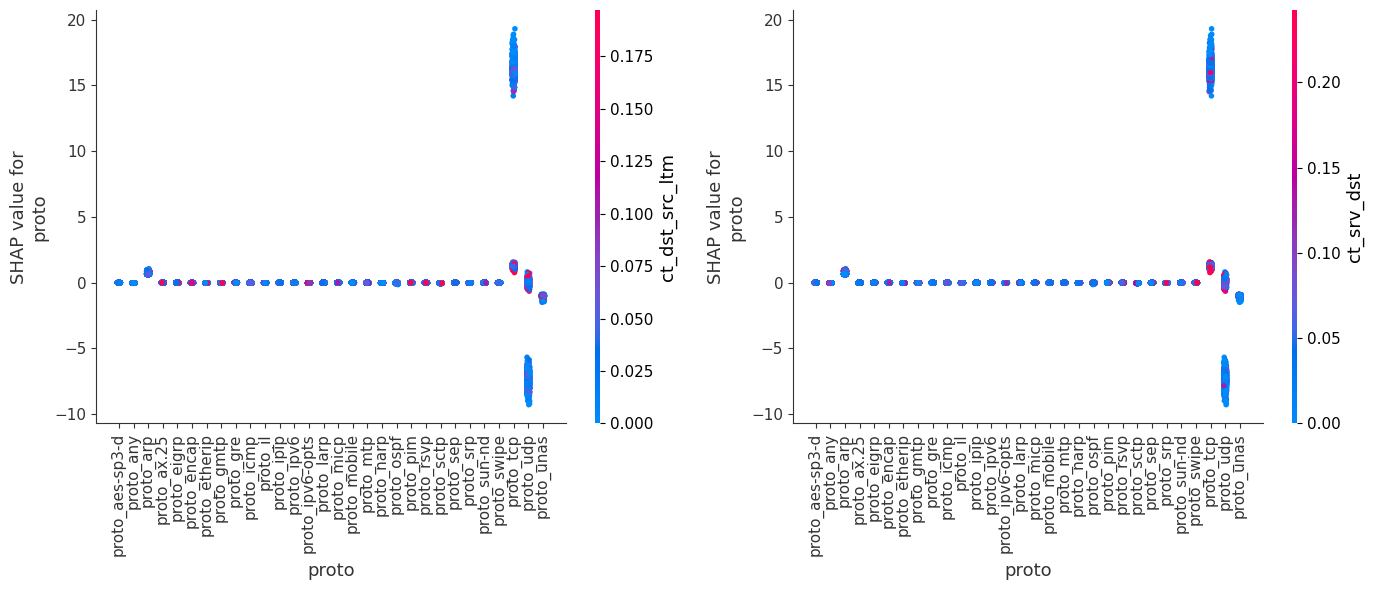

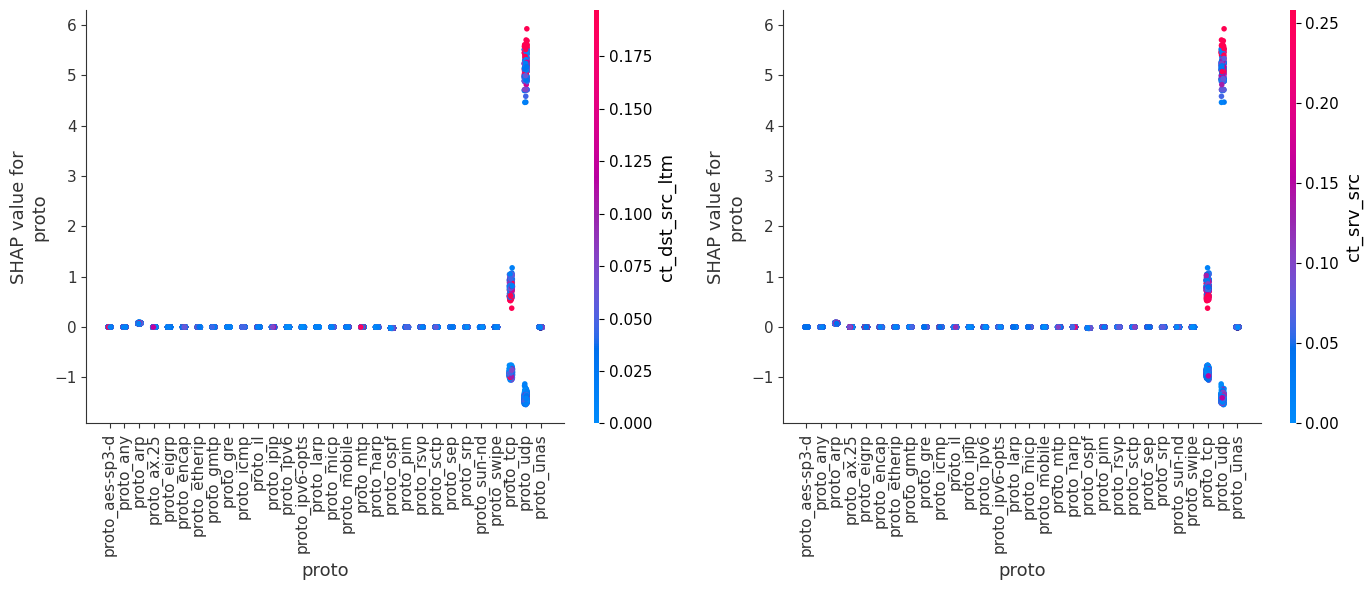

In [70]:
sm1.plot_dependence('proto', n_interaction=2, x_jitter=0.2)
sm2.plot_dependence('proto', n_interaction=2, x_jitter=0.2)

In [71]:
sm1.restore_data()
sm2.restore_data()

In [72]:
sm1.stacked_group('service', limit=30, calculation='average')
sm2.stacked_group('service', limit=30, calculation='average')

For Services the SMOTE Model considers the changes in service binaries much more important than the Standard Model. The SMOTE model considers the Services DNS, FTP, and HTTP very important whereas the Standard Model only considers Service None partially important for some instances. Again we see the same interactions as before where ct_dst_src_ltm is the most important and destination (ct_srv_dst) for SMOTE but source (ct_srv_src) for Standard Model.

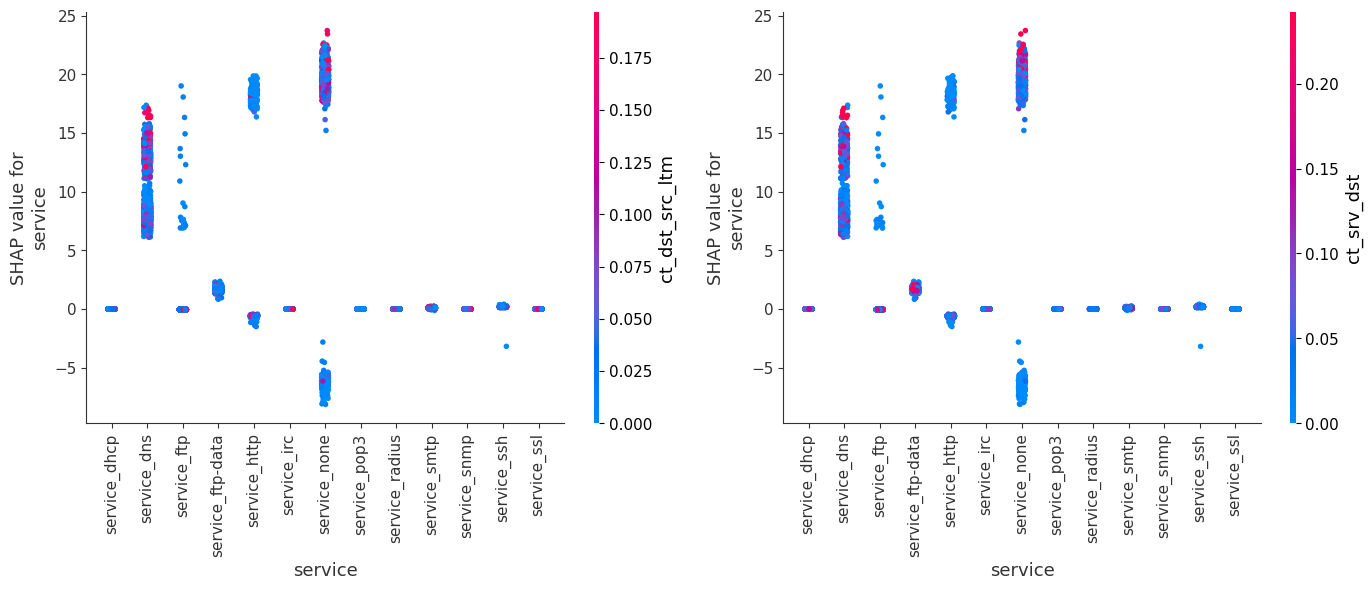

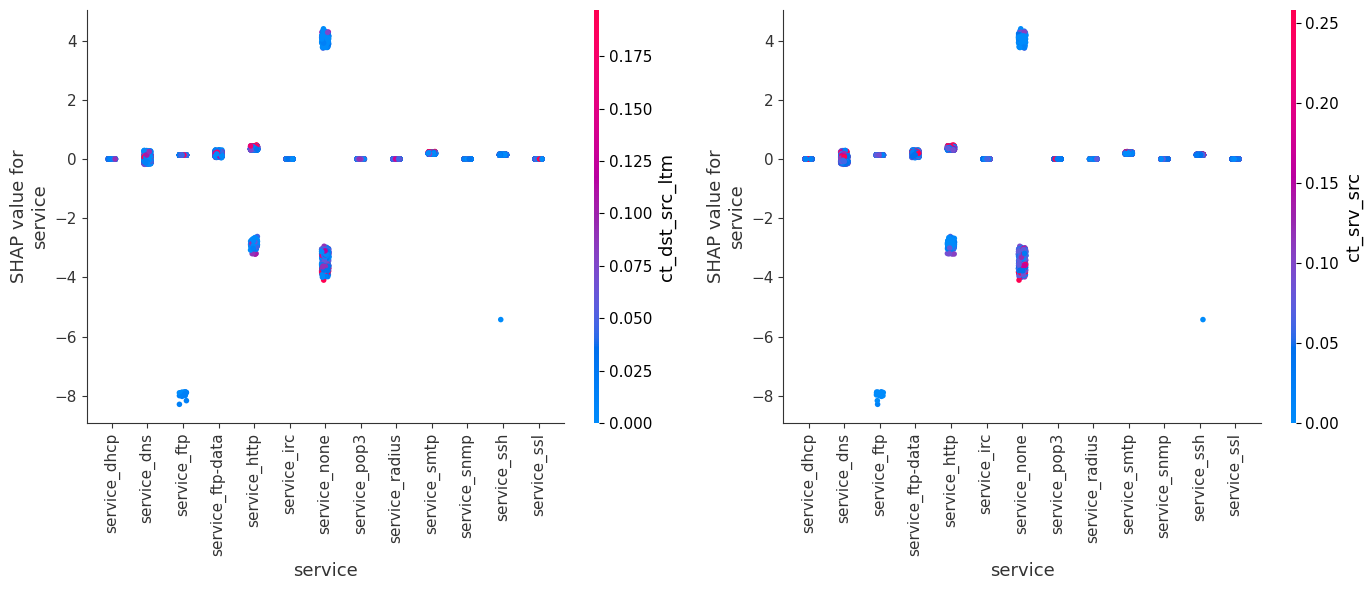

In [73]:
sm1.plot_dependence('service', n_interaction=2, x_jitter=0.2)
sm2.plot_dependence('service', n_interaction=2, x_jitter=0.2)

Finally lets look at State.

In [74]:
sm1.restore_data()
sm2.restore_data()

In [75]:
sm1.stacked_group('state', limit=30, calculation='average')
sm2.stacked_group('state', limit=30, calculation='average')

Again we see the same pattern as before. The SMOTE Model considers State CON and FIN very important whereas the Standard Model considers all State of low importance except for some instances of CON. The Interactions are again the same as before.

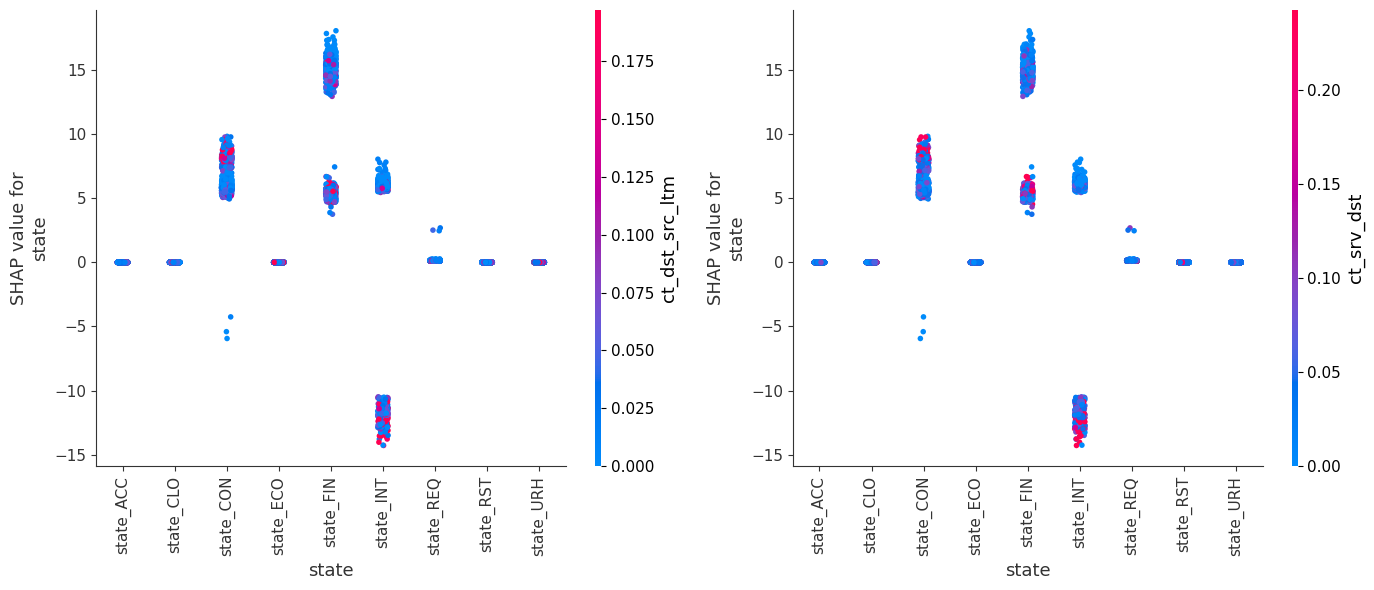

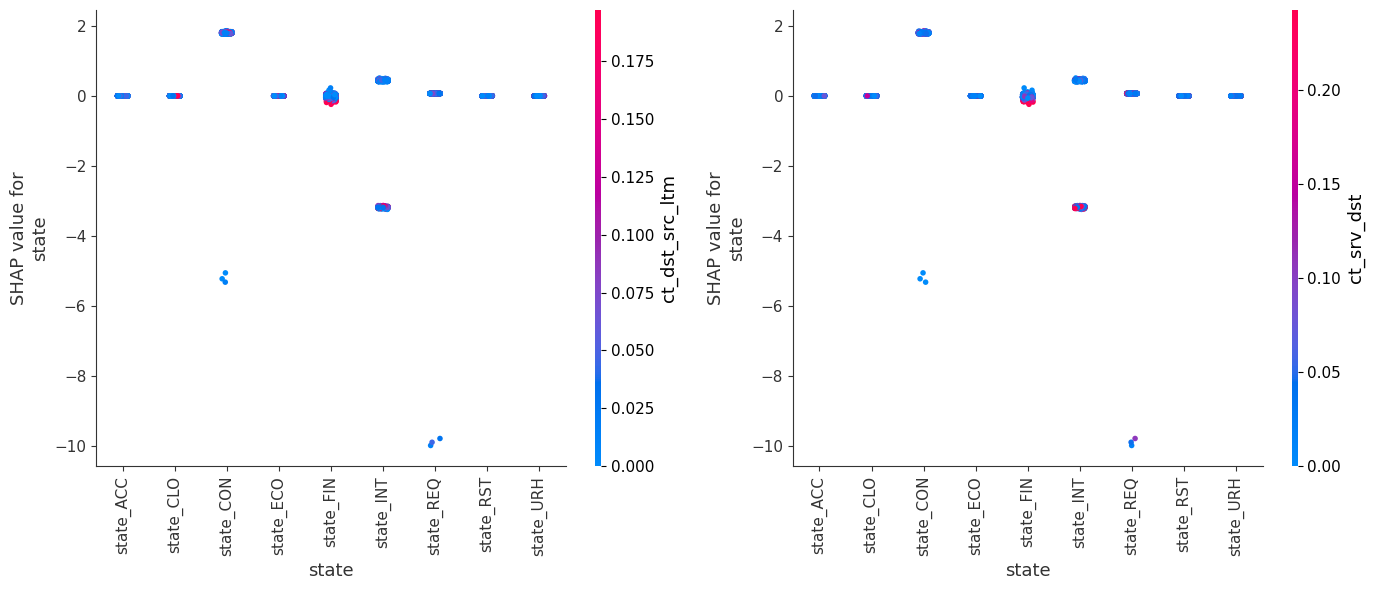

In [76]:
sm1.plot_dependence('state', n_interaction=2, x_jitter=0.2)
sm2.plot_dependence('state', n_interaction=2, x_jitter=0.2)

Conclusion SMOTE vs Standard.

In conclusion, we see a consistent pattern of the SMOTE model scaling up the importance of features particularly for binary one-hot encoded features. Where the Standard Model considers the changes of the binaries of lower importance, the SMOTE Model considers them significantly more important in predicting the label. The visualisations have shown this is consistent across almost all binaries. This could mean that the continuous variables help to predict the Normal values a lot more whereas the binaries help to predict the threats a lot better.